In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost # requirements
import lightgbm # requirements
import catboost # requirements
import os

from bayes_opt import BayesianOptimization, UtilityFunction # requirements
from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

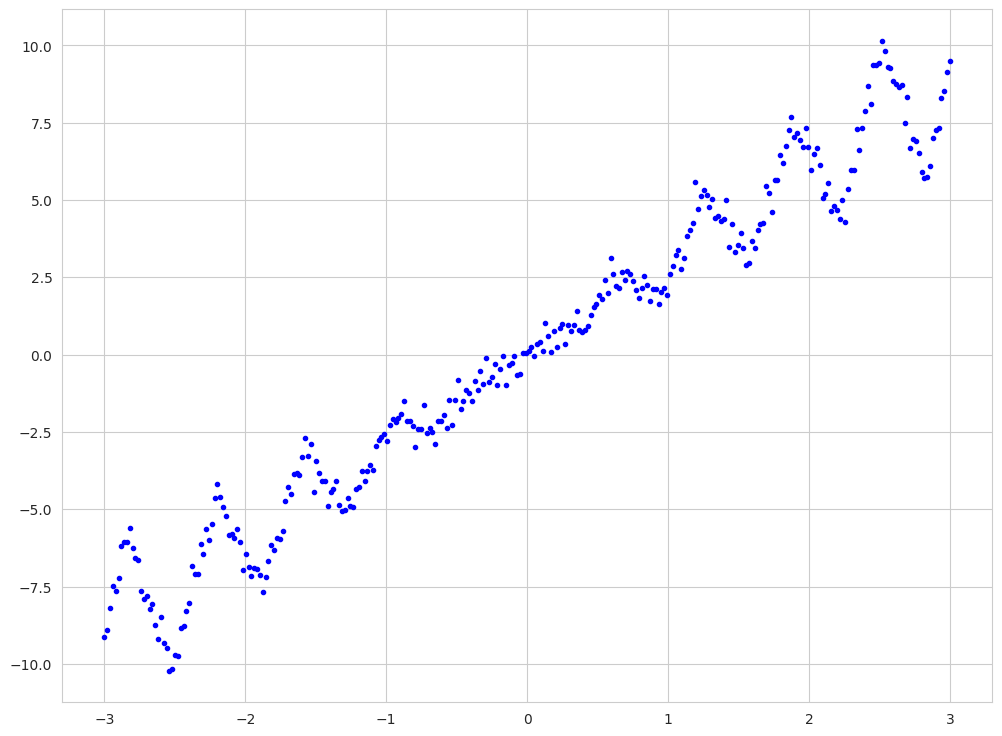

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

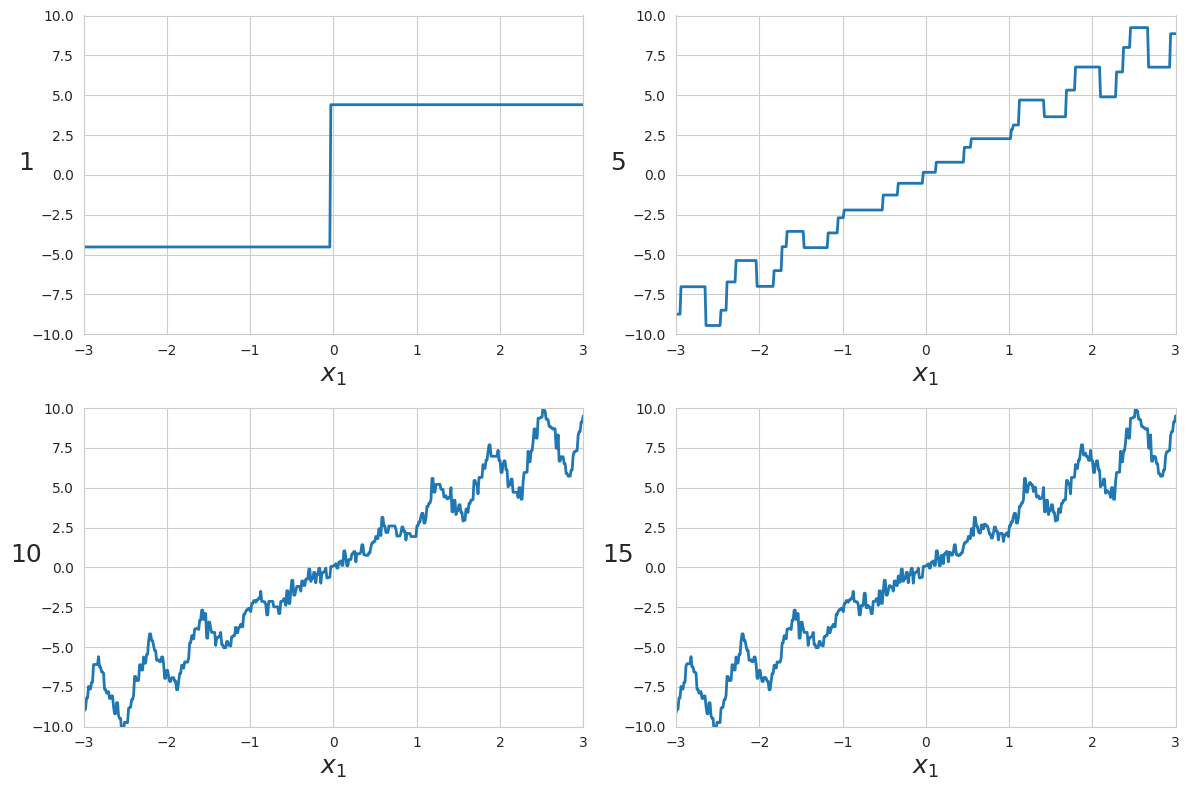

In [5]:
depths = [1, 5, 10, 15]
plt.figure(figsize=(12, 8))
for i, depth in enumerate(depths):
    tree_reg = DecisionTreeRegressor(max_depth=depth)
    tree_reg.fit(X, y)
    plt.subplot(2, 2, i+1)
    plot_regression_predictions(tree_reg, X, y, ylabel=depth)

plt.tight_layout()
plt.show()

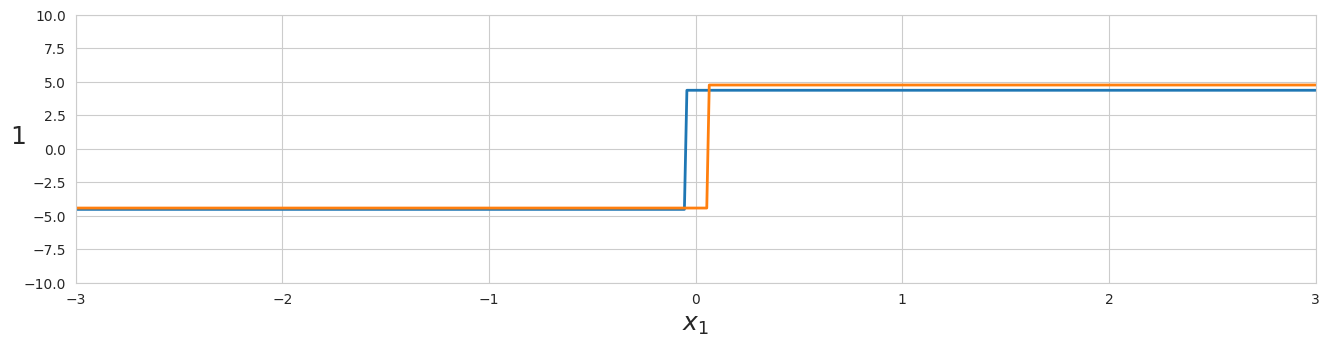

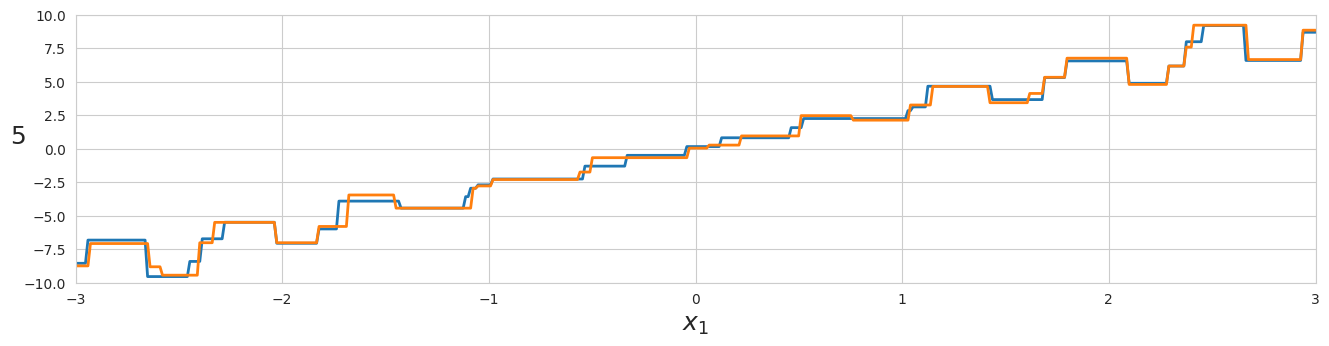

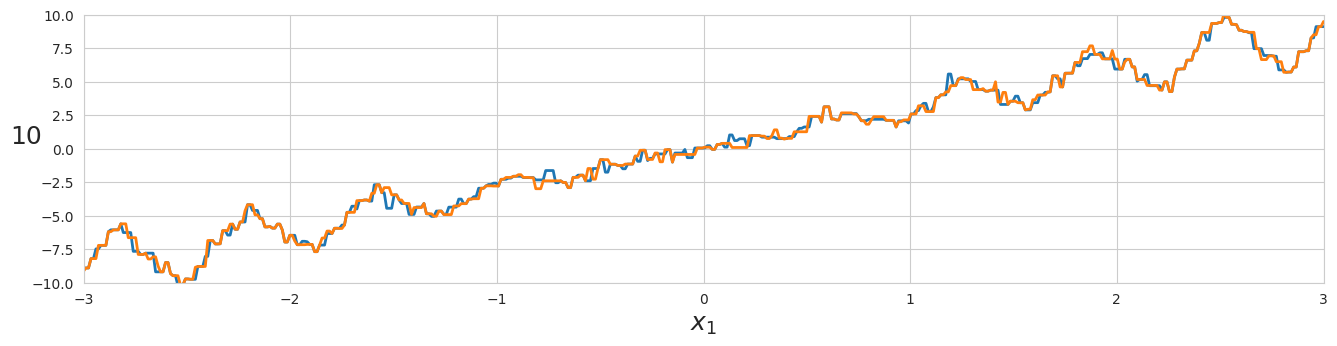

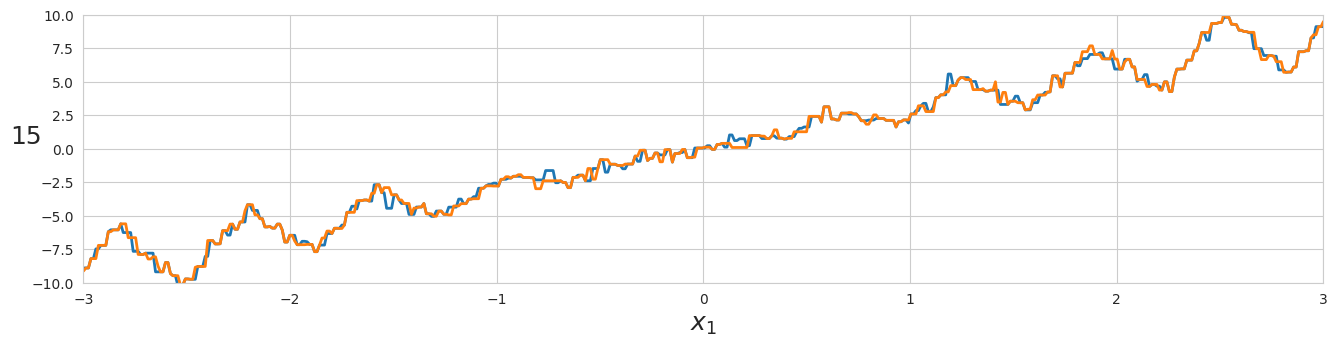

In [6]:
depths = [1, 5, 10, 15]
for i, depth in enumerate(depths):
    # первый набор точек
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, random_state=1)
    clf1 = DecisionTreeRegressor(max_depth=depth, random_state=42)
    clf1.fit(X_train1, y_train1)

    # второй набор точек
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state=2)
    clf2 = DecisionTreeRegressor(max_depth=depth, random_state=42)
    clf2.fit(X_train2, y_train2)
    
    plt.figure(figsize=(16, 16))
    plt.subplot(4, 1, i+1)
    plot_regression_predictions(clf1, X, y, ylabel=depth)
    plot_regression_predictions(clf2, X, y, ylabel=depth)
    plt.show()

Для диапазона глубины от 1 до 15 оптимальным значением является максимальная глубина 10, при данной глубине variance, судя по графикам, не высокий и не отличается от varince для дерева глубиной 15. Но также и графики от дерева глубиной 15 не отличаются, значит дерево глубиной 10 описывает данные, также хорошо, как и глубиной 15, но при этом меньшая глубина безопаснее, чтобы избежать переобучения.

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

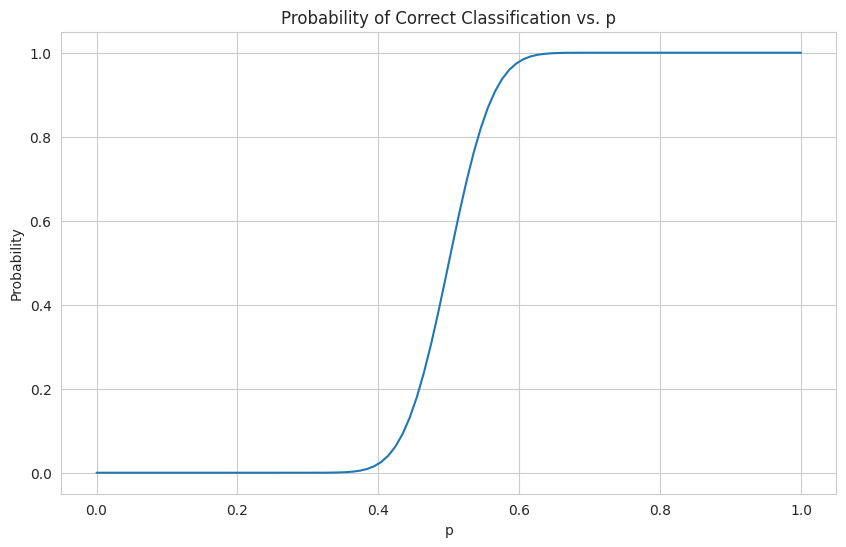

In [7]:
ps = np.linspace(0, 1, 100)
probs = []

for p in ps:
    prob_correct = 0
    for i in range(51, 102):
        prob_correct += math.comb(101, i) * p**i * (1-p)**(101-i)
    probs.append(prob_correct)

plt.figure(figsize=(10, 6))
plt.plot(ps, probs)
plt.xlabel('p')
plt.ylabel('Probability')
plt.title('Probability of Correct Classification vs. p')
plt.grid(True)
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

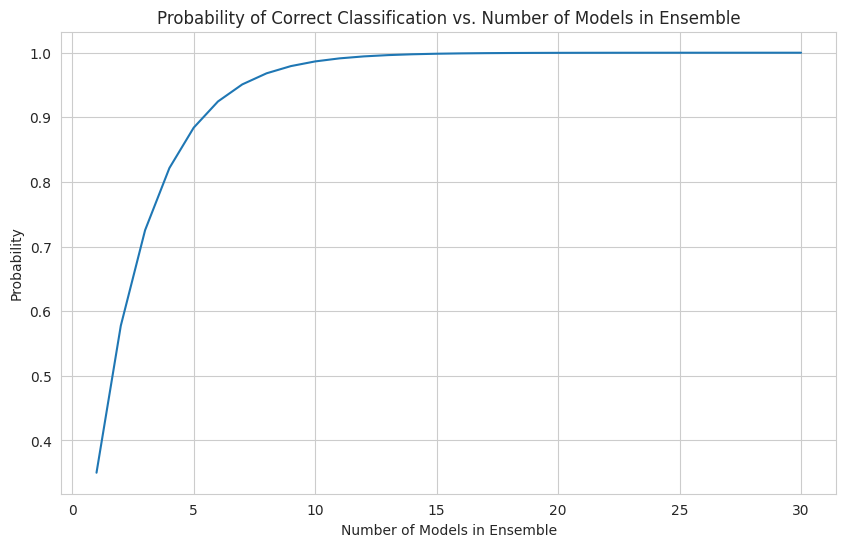

In [8]:
p = 0.65
n_models = np.arange(1, 31)
probs = []

for n in n_models:
    prob_correct = 0
    for k in range(n, n+1):
        prob_correct += 1 - math.comb(n, k) * (p**k) * ((1-p)**(n-k))
    probs.append(prob_correct)

plt.figure(figsize=(10, 6))
plt.plot(n_models, probs)
plt.xlabel('Number of Models in Ensemble')
plt.ylabel('Probability')
plt.title('Probability of Correct Classification vs. Number of Models in Ensemble')
plt.grid(True)
plt.show()


Опишите ваши наблюдения:

Для графика зависимости вероятности правильно классифицировать объект от значения p
* При малых значениях p вероятность правильной классификации объекта также будет невелика, поскольку большинство классификаторов будут ошибаться в предсказаниях. С увеличением значения p вероятность правильной классификации объекта возрастает. Это связано с тем, что при более высокой вероятности правильного предсказания каждого классификатора вероятность того, что большинство из них правильно предскажет класс объекта, также увеличивается. При p=0.5 вероятность правильной классификации объекта будет примерно равна 0.5, так как это случай, когда классификаторы предсказывают случайным образом. При очень высоких значениях p вероятность правильной классификации объекта стремится к 1, так как практически все классификаторы будут делать правильные предсказания.

Для графика зависимости вероятности правильно классифицировать объект от числа моделей в ансамбле

* Увеличение числа моделей в ансамбле приводит к увеличению вероятности правильной классификации объекта. Это связано с тем, что при наличии большего числа моделей в ансамбле вероятность того, что хотя бы одна из них правильно классифицирует объект, становится выше. . В начале увеличение числа моделей в ансамбле приводит к более резкому росту вероятности правильной классификации, но затем этот рост становится менее выраженным. Это связано с тем, что с увеличением числа моделей в ансамбле уменьшается вероятность ошибки каждой отдельной модели, но при достаточно большом числе моделей дополнительное увеличение их числа оказывает меньшее влияние на общую вероятность правильной классификации.

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [9]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            if self.max_features is None:
                feat_ids = np.arange(X.shape[1])
            else:
                feat_ids = np.random.choice(range(X.shape[1]), size=self.max_features, replace=False)
            self.feat_ids_by_tree.append(feat_ids)

            indices = np.random.choice(range(X.shape[0]), X.shape[0], replace=True)
            X_bootstrap = X[indices]
            y_bootstrap = y[indices]

            tree = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X_bootstrap[:, feat_ids], y_bootstrap)
            self.trees.append(tree)

            return self

    def predict_proba(self, X):
        probas = np.zeros((X.shape[0], len(self.classes_)))

        for i, tree in enumerate(self.trees):
            feat_ids = self.feat_ids_by_tree[i]
            probas += tree.predict_proba(X[:, feat_ids])

        probas /= len(self.trees)

        return probas
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [10]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

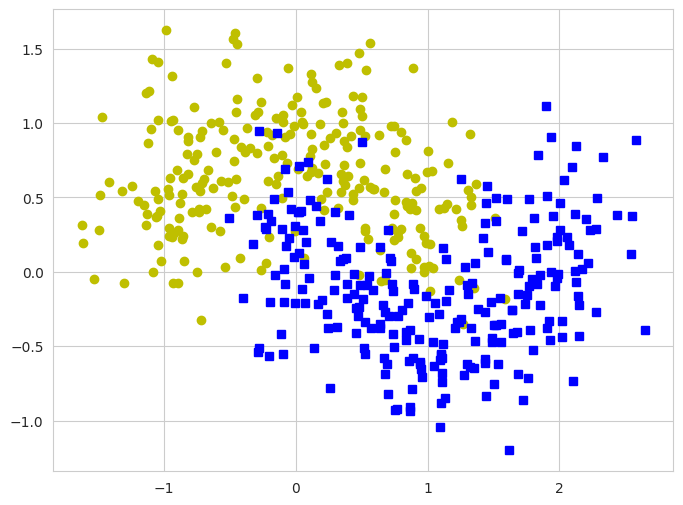

In [11]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

([], [])

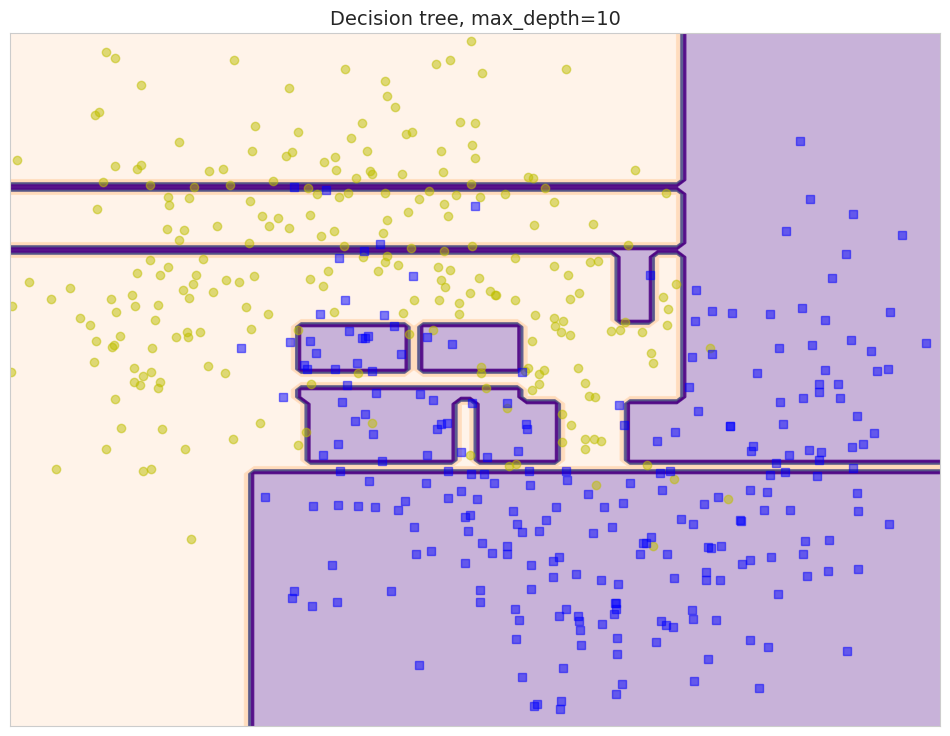

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
dt1 = RandomForestClassifierCustom(max_depth=10)
dt1.fit(X_train, y_train)
plot_decision_boundary(dt1, X, y)
plt.xticks([], [])
plt.yticks([], [])
plt.title("Decision tree, max_depth=10", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

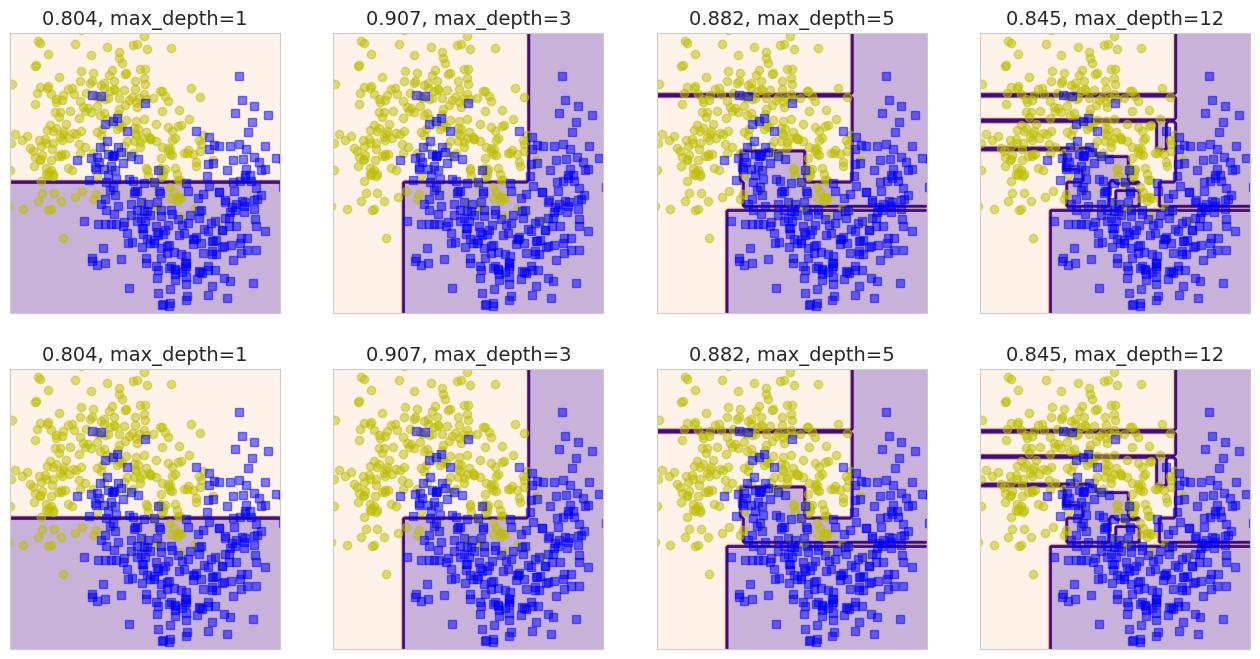

In [13]:
plt.figure(figsize=(16, 8))

plt.subplot(241)
dt1 = RandomForestClassifierCustom(max_depth=1)
dt1.fit(X_train, y_train)
y_pred1 = dt1.predict_proba(X_test)[:, 1]
qual1 = round(roc_auc_score(y_true=y_test, y_score=y_pred1), 3)
plot_decision_boundary(dt1, X, y)
plt.xticks([], [])
plt.yticks([], [])
plt.title(f"{qual1}, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(242)
dt3 = RandomForestClassifierCustom(max_depth=3)
dt3.fit(X_train, y_train)
y_pred3 = dt3.predict_proba(X_test)[:, 1]
qual3 = round(roc_auc_score(y_true=y_test, y_score=y_pred3), 3)
plot_decision_boundary(dt3, X, y)
plt.title(f"{qual3}, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(243)
dt5 = RandomForestClassifierCustom(max_depth=5)
dt5.fit(X_train, y_train)
y_pred5 = dt5.predict_proba(X_test)[:, 1]
qual5 = round(roc_auc_score(y_true=y_test, y_score=y_pred5), 3)
plot_decision_boundary(dt5, X, y)
plt.title(f"{qual5}, max_depth=5", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(244)
dt12 = RandomForestClassifierCustom(max_depth=12)
dt12.fit(X_train, y_train)
y_pred12 = dt12.predict_proba(X_test)[:, 1]
qual12 = round(roc_auc_score(y_true=y_test, y_score=y_pred12), 3)
plot_decision_boundary(dt12, X, y)
plt.title(f"{qual12}, max_depth=12", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(245)
rf1 = RandomForestClassifierCustom(max_depth=1)
rf1.fit(X_train, y_train)
y_pred13 = rf1.predict_proba(X_test)[:, 1]
qual13 = round(roc_auc_score(y_true=y_test, y_score=y_pred13), 3)
plot_decision_boundary(rf1, X, y)
plt.title(f"{qual13}, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(246)
rf3 = RandomForestClassifierCustom(max_depth=3, n_estimators=500)
rf3.fit(X_train, y_train)
y_pred14 = rf3.predict_proba(X_test)[:, 1]
qual14 = round(roc_auc_score(y_true=y_test, y_score=y_pred14), 3)
plot_decision_boundary(rf3, X, y)
plt.title(f"{qual14}, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(247)
rf5 = RandomForestClassifierCustom(max_depth=5, n_estimators=500)
rf5.fit(X_train, y_train)
y_pred15 = rf5.predict_proba(X_test)[:, 1]
qual15 = round(roc_auc_score(y_true=y_test, y_score=y_pred15), 3)
plot_decision_boundary(rf5, X, y)
plt.title(f"{qual15}, max_depth=5", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(248)
rf12 = RandomForestClassifierCustom(max_depth=12, n_estimators=500)
rf12.fit(X_train, y_train)
y_pred16 = rf12.predict_proba(X_test)[:, 1]
qual16 = round(roc_auc_score(y_true=y_test, y_score=y_pred16), 3)
plot_decision_boundary(rf12, X, y)
plt.title(f"{qual16}, max_depth=12", fontsize=14)
plt.subplots_adjust()
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], []);

Наиболее подходящим гиперпараметром показался max_depth=3 по графику и roc_auc_score. Разные n_estimators не изменяют модель.

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [14]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [15]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

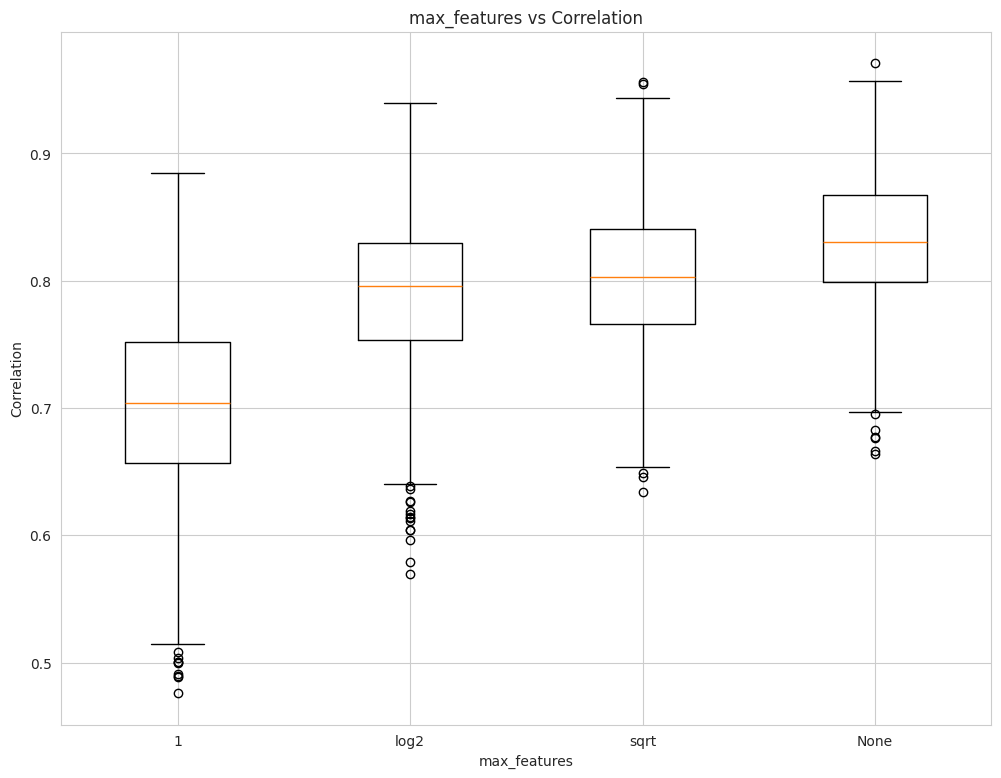

In [16]:
max_features_list = [1, 'log2', 'sqrt', None]
cor_res = []

for max_features in max_features_list:
    rf_model = RandomForestClassifier(n_estimators=50, max_features=max_features, random_state=42)
    rf_model.fit(X_train, y_train)

    corrs = base_model_pair_correlation(rf_model, X_test)
    cor_res.append(corrs)

plt.boxplot(cor_res, labels=[1, 'log2', 'sqrt', 'None'])
plt.xlabel('max_features')
plt.ylabel('Correlation')
plt.title('max_features vs Correlation')
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

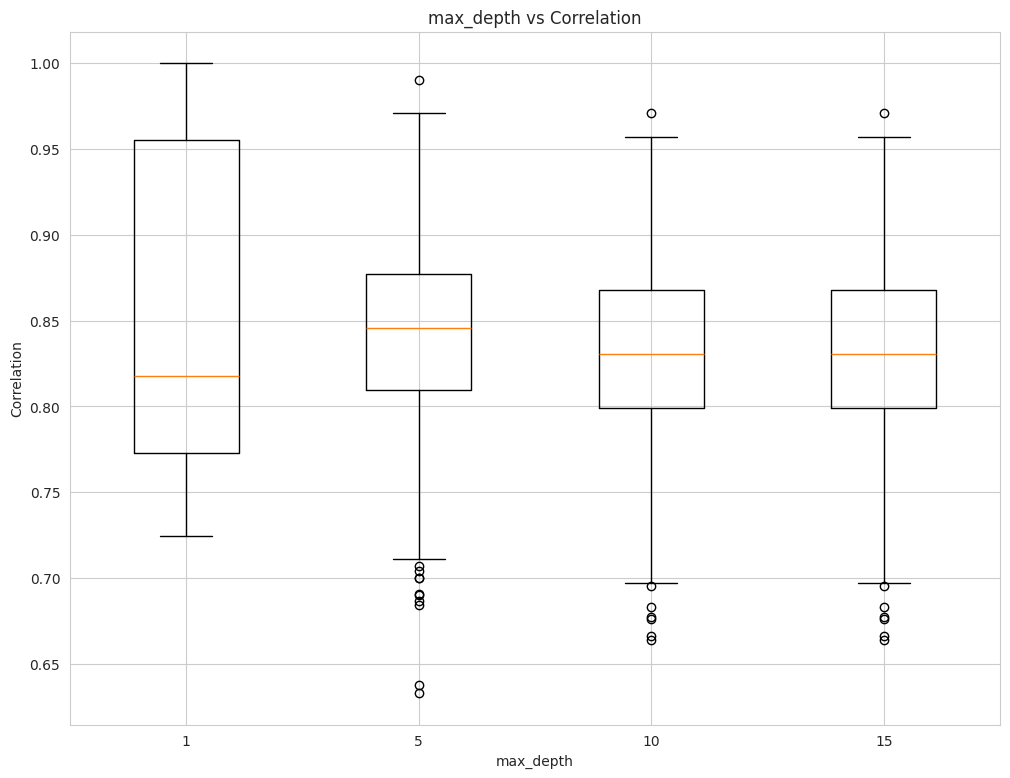

In [17]:
max_depth_list = [1, 5, 10, 15]
cor_res = []

for max_depth in max_depth_list:
    rf_model = RandomForestClassifier(n_estimators=50, max_depth=max_depth, max_features=None, random_state=42)
    rf_model.fit(X_train, y_train)

    corrs = base_model_pair_correlation(rf_model, X_test)
    cor_res.append(corrs)

plt.boxplot(cor_res, labels=max_depth_list)
plt.xlabel('max_depth')
plt.ylabel('Correlation')
plt.title('max_depth vs Correlation')
plt.show()

Влияние параметра max_depth на корреляцию базовых моделей в случайном лесу
* При увеличении глубины деревьев, особенно в сочетании с большим количеством деревьев в случайном лесу, деревут нинаютть строить более похожие структуры разделения. Если каждое дерево идет в глубину и разделяет данные на более мелкие подгруппы, схожесть структет сновитсять более выражено
* Глубокие деревья имеют больше возможности подстраиваться под особенности тренировочных данных, приводитести к уменьшению разнообразия в предсказаниях различных деревьев в анбле
* Падение корреляции при больших значениях может происходить из-за переобучения и выского variance.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [18]:
heart_dataset = pd.read_csv("../data/heart.csv")

In [19]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
178   43    1   0       120   177    0        0      120      1      2.5   
298   57    0   0       140   241    0        1      123      1      0.2   
201   60    1   0       125   258    0        0      141      1      2.8   
246   56    0   0       134   409    0        0      150      1      1.9   
153   66    0   2       146   278    0        0      152      0      0.0   

     slope  ca  thal  
178      1   0     3  
298      1   0     3  
201      1   1     3  
246      1   2     3  
153      1   1     2

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [20]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [21]:
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.8281746031746032
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [22]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [23]:
base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]
all_combinations = []
for r in range(1, 3):
    all_combinations.extend(combinations(base_models, r))
all_combinations
best_score = 0
best_combination = None

for combination in all_combinations:
    ensemble = VotingClassifier(estimators=list(combination), voting='soft')
    ensemble.fit(X_train, y_train)
    scores = cross_val_score(ensemble, X_train, y_train, cv=3, scoring="f1")
    mean_score = scores.mean()
    correlations = base_model_pair_correlation_for_voting_clf(ensemble, X_test)
    if mean_score > best_score and all(corr[2] < 0.95 for corr in correlations):
        best_score = mean_score
        best_combination = combination

print("Best Combination:", best_combination)
print("Best Score:", best_score)

[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

Best Combination: (('CAT', <catboost.core.CatBoostClassifier object at 0x7f3f5fe1df10>), ('LR', LogisticRegression(max_iter=10000, solver='liblinear')))
Best Score: 0.8694543828264759

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [24]:
data = pd.read_csv("../data/churn.csv")
data.head()

State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0    KS             128        415  382-4657         no        yes   
1    OH             107        415  371-7191         no        yes   
2    NJ             137        415  358-1921         no         no   
3    OH              84        408  375-9999        yes         no   
4    OK              75        415  330-6626        yes         no   

   VMail Message  Day Mins  Day Calls  Day Charge  ...  Eve Calls  Eve Charge  \
0             25     265.1        110       45.07  ...         99       16.78   
1             26     161.6        123       27.47  ...        103       16.62   
2              0     243.4        114       41.38  ...        110       10.30   
3              0     299.4         71       50.90  ...         88        5.26   
4              0     166.7        113       28.34  ...        122       12.61   

   Night Mins  Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  \
0       244.7           91         11.01       10.0           3         2.70   
1       254.4          103         11.45       13.7           3         3.70   
2       162.6          104          7.32       12.2           5         3.29   
3       196.9           89          8.86        6.6           7         1.78   
4       186.9          121          8.41       10.1           3         2.73   

   CustServ Calls  Churn?  
0               1  False.  
1               1  False.  
2               0  False.  
3               2  False.  
4               3  False.  

[5 rows x 21 columns]

In [25]:
print("Info:")
print(data.info(), "\n\n")
print("Statistical characteristics of the numerical features:\n", data.describe(), "\n\n")
def count_missing_values(df):
    missing_values = {}
    for column in df.columns:
        count = df[column].isnull().sum()
        if count > 0:
            missing_values[column] = count
    return missing_values

result = count_missing_values(data)
print("Column with missing value:\n", result)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-nu

In [26]:
data = data.drop('Phone', axis=1)
data = data.drop('State', axis=1)

In [27]:
data["Int'l Plan"] = data["Int'l Plan"].map(dict(yes=1, no=0))
data["VMail Plan"] = data["VMail Plan"].map(dict(yes=1, no=0))
data["Churn?"] = pd.Series(np.searchsorted(['False.', 'True.'], data["Churn?"].values), data.index)
data.head()

Account Length  Area Code  Int'l Plan  VMail Plan  VMail Message  Day Mins  \
0             128        415           0           1             25     265.1   
1             107        415           0           1             26     161.6   
2             137        415           0           0              0     243.4   
3              84        408           1           0              0     299.4   
4              75        415           1           0              0     166.7   

   Day Calls  Day Charge  Eve Mins  Eve Calls  Eve Charge  Night Mins  \
0        110       45.07     197.4         99       16.78       244.7   
1        123       27.47     195.5        103       16.62       254.4   
2        114       41.38     121.2        110       10.30       162.6   
3         71       50.90      61.9         88        5.26       196.9   
4        113       28.34     148.3        122       12.61       186.9   

   Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  \
0           91         11.01       10.0           3         2.70   
1          103         11.45       13.7           3         3.70   
2          104          7.32       12.2           5         3.29   
3           89          8.86        6.6           7         1.78   
4          121          8.41       10.1           3         2.73   

   CustServ Calls  Churn?  
0               1       0  
1               1       0  
2               0       0  
3               2       0  
4               3       0

In [28]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account Length  3333 non-null   int64  
 1   Area Code       3333 non-null   int64  
 2   Int'l Plan      3333 non-null   int64  
 3   VMail Plan      3333 non-null   int64  
 4   VMail Message   3333 non-null   int64  
 5   Day Mins        3333 non-null   float64
 6   Day Calls       3333 non-null   int64  
 7   Day Charge      3333 non-null   float64
 8   Eve Mins        3333 non-null   float64
 9   Eve Calls       3333 non-null   int64  
 10  Eve Charge      3333 non-null   float64
 11  Night Mins      3333 non-null   float64
 12  Night Calls     3333 non-null   int64  
 13  Night Charge    3333 non-null   float64
 14  Intl Mins       3333 non-null   float64
 15  Intl Calls      3333 non-null   int64  
 16  Intl Charge     3333 non-null   float64
 17  CustServ Calls  3333 non-null   i

In [29]:
X = data.drop('Churn?', axis=1)
y = data['Churn?']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
xgb_model = xgboost.XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [32]:
lgbm_model = lightgbm.LGBMClassifier()
lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 382, number of negative: 2284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2388
[LightGBM] [Info] Number of data points in the train set: 2666, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143286 -> initscore=-1.788263
[LightGBM] [Info] Start training from score -1.788263


LGBMClassifier()

In [33]:
xgb_predictions = xgb_model.predict(X_test)
lgbm_predictions = lgbm_model.predict(X_test)

In [34]:
print("XGBoost Classifier:")
print("f1_score:", f1_score(y_test, xgb_predictions))

print("\nLGBM Classifier:")
print("f1_score:", f1_score(y_test, lgbm_predictions))

XGBoost Classifier:
f1_score: 0.8415300546448088

LGBM Classifier:
f1_score: 0.8351648351648352


In [35]:
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [8, 10, 20, 30],
    'n_estimators': [50, 100, 200]
}

xgb_tuned_model = GridSearchCV(xgboost.XGBClassifier(), xgb_params, cv=3)
xgb_tuned_model.fit(X_train, y_train)
xgb_tuned_predictions = xgb_tuned_model.predict(X_test)

print("Tuned XGBoost Classifier:")
print("Best Parameters:", xgb_tuned_model.best_params_)
print("f1_score:", f1_score(y_test, xgb_tuned_predictions))

lgbm_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [8, 15, 20, 30],
    'n_estimators': [50, 100, 200]
}

lgbm_tuned_model = GridSearchCV(lightgbm.LGBMClassifier(), lgbm_params, cv=3)
lgbm_tuned_model.fit(X_train, y_train)
lgbm_tuned_predictions = lgbm_tuned_model.predict(X_test)

print("\nTuned LGBM Classifier:")
print("Best Parameters:", lgbm_tuned_model.best_params_)
print("f1_score:", f1_score(y_test, lgbm_tuned_predictions))

Tuned XGBoost Classifier:
Best Parameters: {'learning_rate': 0.2, 'max_depth': 20, 'n_estimators': 50}
f1_score: 0.8404255319148937
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 255, number of negative: 1522
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2329
[LightGBM] [Info] Number of data points in the train set: 1777, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143500 -> initscore=-1.786517
[LightGBM] [Info] Start trai

Способ по совету how to choose best hyperparameters for lightgbm:

In [36]:
def bayes_parameter_opt_lgb(X, y, init_round=20, opt_round=30, n_folds=5, random_seed=6, n_estimators=10000,
                            learning_rate=0.05, output_process=False):

    train_data = lightgbm.Dataset(data=X, label=y)

    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, 
                 lambda_l1, lambda_l2, min_split_gain, min_child_weight):

        params = {'objective': 'regression', 'num_iterations': 1000, 'learning_rate': 0.05,
                  'early_stopping_round': 100, 'metric': 'rmse', 'verbose_eval': 200}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        
        cv_result = lightgbm.cv(params, train_data, nfold=3, seed=random_seed,
                                stratified=False, metrics=['rmse'])

        return min(cv_result['valid rmse-mean'])

    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.5, 1),
                                            'max_depth': (5, 8.99),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 60)}, random_state=0)
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    if output_process:
        lgbBO.points_to_csv("bayes_opt_result.csv")
    
    return lgbBO

opt_params = bayes_parameter_opt_lgb(X_train, y_train, init_round=5, opt_round=10, n_folds=3,
                                     random_seed=6, n_estimators=10000, learning_rate=0.05)


|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2388
[LightGBM] [Info] Number of data points in the train set: 1776, number of used features: 18
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[Light

In [37]:
params = opt_params.max['params']

In [38]:
params

{'bagging_fraction': 1.0,
 'feature_fraction': 0.1,
 'lambda_l1': 5.0,
 'lambda_l2': 0.0,
 'max_depth': 5.0,
 'min_child_weight': 48.318936979058,
 'min_split_gain': 0.1,
 'num_leaves': 24.0}

In [39]:
params = {
    "objective" : "regression",
    "metric" : "rmse",
    "bagging_frequency" : 5,
    "bagging_seed" : 2018,
    "verbosity" : -1,

    # Selected rounded-off params
    'bagging_fraction': 1.0,
    'feature_fraction': 0.1,
    'lambda_l1': 5.0,
    'lambda_l2': 0.0,
    'max_depth': 5,
    'min_child_weight': 48,
    'min_split_gain': 0.1,
    'num_leaves': 24
}

In [40]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    lgtrain = lightgbm.Dataset(train_X, label=train_y)
    lgval = lightgbm.Dataset(val_X, label=val_y)
    evals_result = {}
    params['early_stopping_rounds'] = 100
    params['verbosity'] = 100
    model = lightgbm.train(params, lgtrain, 1000, valid_sets=[lgval])
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

pred_test = 0
kf = KFold(n_splits=5, random_state=2018, shuffle=True)

for dev_index, val_index in kf.split(X_train):
    dev_X, val_X = X_train.iloc[dev_index,:], X_train.iloc[val_index,:]
    dev_y, val_y = y_train.iloc[dev_index], y_train.iloc[val_index]
    
    pred_test_tmp, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, X_test)
    pred_test += pred_test_tmp
pred_test /= 5.

[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.788462
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.143892
[LightGBM] [Debug] init for col-wise cost 0.000104 seconds, init for row-wise cost 0.000256 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2355
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 18
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.149156
[LightGBM] [Warning] No further splits with positive gain, best gain

In [41]:
threshold = 0.5
binary_predictions = (pred_test > threshold).astype(int)
f1 = f1_score(y_test, binary_predictions)
print(f"F1 Score: {f1}")

F1 Score: 0.29457364341085274


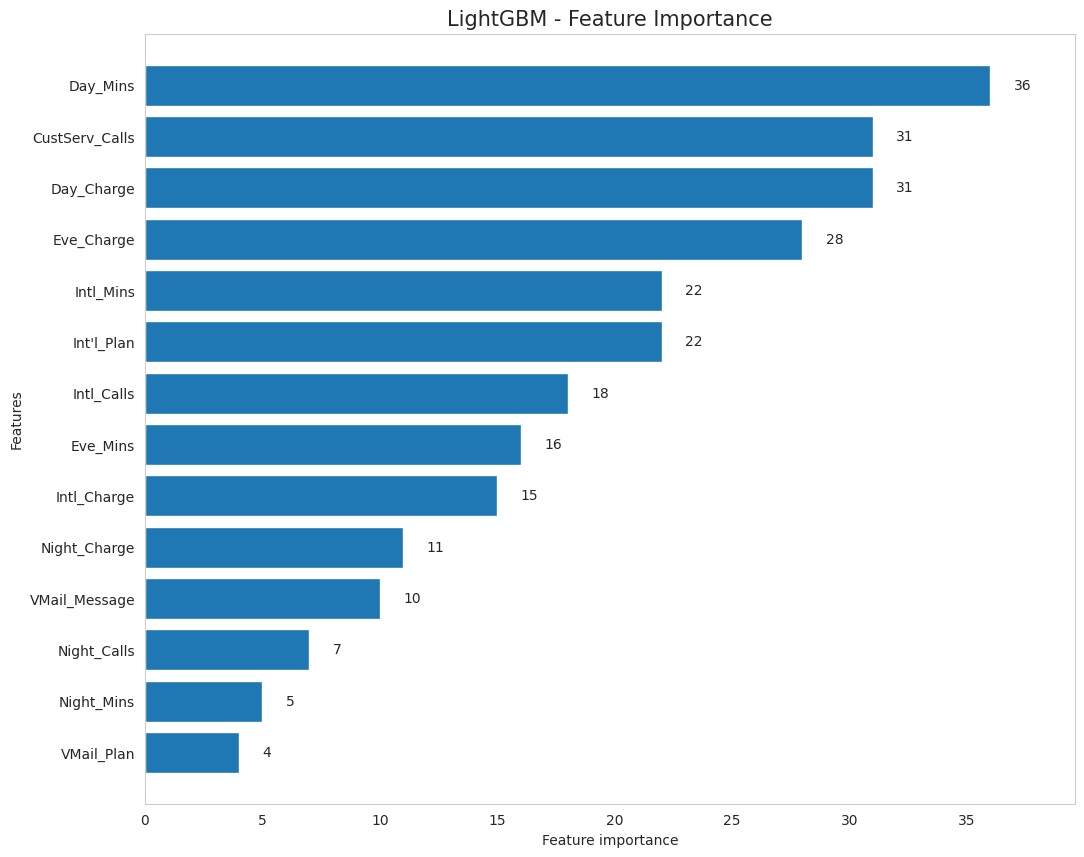

In [42]:
fig, ax = plt.subplots(figsize=(12,10))
lightgbm.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

Я разобралась в этом на половину, было тяжело и не получилось, но мне было весело. Надеюсь, в будущем смогу полностью осознать.

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**